In [1]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
import data_generator as dg
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline  

Get data array from generate_data module. Randomize the array. Pick sample_size amount from each

In [2]:
#get positive images, determine best ratios (rows over columns), assign to images
def remove_red(img):
    img[:,:,2] = 0
    return img

pimages = dg.getImagesFromJSON(open("labels.json").read())
pimages = [remove_red(x) for x in pimages]
print(len(pimages))

270


Separate positive images into aspect ratios, get negative images and crop to aspect ratios

In [3]:
#get negative images, use ratios found for positive images to match
nimages = dg.getRandomMultiple("sun_images", 200, 0)
partialsignimgs = dg.getRandomMultiple("partial", 200, 0)
nimages = nimages+partialsignimgs
nimages = [x[1] for x in nimages]

print(len(nimages))


400


Generate features from HOGs and images for each label and aspect ratio

In [4]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data


In [5]:
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 2.1e-1
gammaCorrection = 0
nlevels = 64

dims = (80,80)

hog = cv2.HOGDescriptor(dims,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [6]:
pdata = getFeaturesWithLabel(pimages, hog, dims, 1)
ndata = getFeaturesWithLabel(nimages, hog, dims, 0)

data = pdata + ndata
shuffle(data)

feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

sample_size = len(feat)
train_size = int(round(0.8*sample_size))


In [7]:
train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])


Train classifier

In [8]:
lsvm = svm.SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(train_feat, train_label)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute and display training accuracy

In [9]:
print(lsvm.score(train_feat, train_label))

1.0


Compute and display test set accuracy, precision, recall, f1-score

In [10]:
#compute test accuracy
print("test accuracy ", lsvm.score(test_feat, test_label))
y_pred = lsvm.predict(test_feat)
print(classification_report(test_label, y_pred))

test accuracy  0.925373134328
             precision    recall  f1-score   support

          0       0.94      0.94      0.94        82
          1       0.90      0.90      0.90        52

avg / total       0.93      0.93      0.93       134



Confusion Matrix

In [11]:
confusion_matrix(y_pred, test_label)

array([[77,  5],
       [ 5, 47]])

Find and display signs in a test image

In [12]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

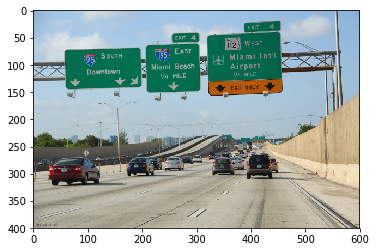

In [13]:
im = cv2.imread("multiscale_test/191.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

Preprocess image, get regions of interest bounding boxes using contours, color filtering, thresholding

In [14]:
def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")
    
    #apply smoothing
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(image,-1,kernel)

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output, mask

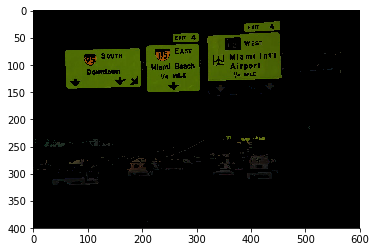

In [15]:
pimage, mask = preprocess(im,  [0,0,0], [255, 255, 40])
plt.imshow(pimage)
plt.show()

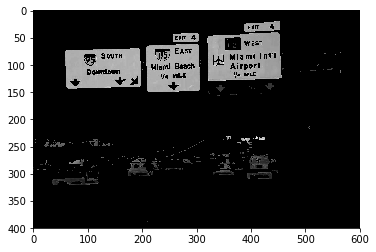

In [16]:
imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

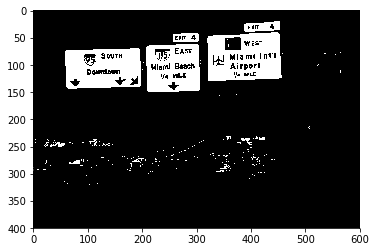

In [17]:
flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
plt.imshow(binaryImage, cmap='gray')
plt.show()

In [18]:
im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

442
6


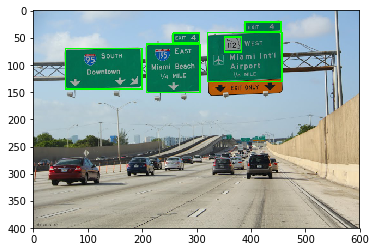

In [19]:
copy = im.copy()
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print(len(boxes2))

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

Apply HOG to bounding boxes for result

In [20]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

In [21]:
real_signs = []

for x, y, w, h in boxes2:
    #get slice at box:
    window = im[y:y+h, x:x+w, :3]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
#     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
#     plt.show()
#     print prob[1]
    if prob[1] > .1:  
        real_signs.append((x,y,w,h))
    
print(len(real_signs))


6


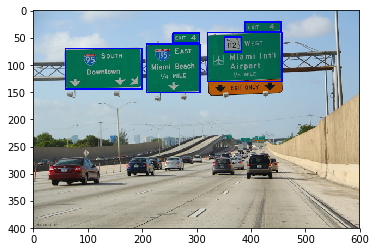

In [22]:
clone = im.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
for x, y, w, h in real_signs:
     

    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[3], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()